In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [2]:
df = pd.read_csv('./Wine_red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df_test = df.sample(frac=0.2,replace=False,random_state=0).copy()
df_train = df.drop(df_test.index).copy()

features_train = df_train.drop('quality',axis=1)
features_test = df_test.drop('quality',axis=1)

target_train = df_train.quality
target_test = df_test.quality

In [4]:
# Stage 1
tree1 = DecisionTreeRegressor(max_depth=2)
tree1.fit(features_train,target_train)
target_train_predict = tree1.predict(features_train)
target_test_predict = tree1.predict(features_test)
R2_train = r2_score(target_train,target_train_predict)
R2_test = r2_score(target_test,target_test_predict)
print('stage 1')
print('train R2 = ', R2_train.round(3), 'test R2 = ', R2_test.round(3))

stage 1
train R2 =  0.271 test R2 =  0.204


Likely that it's underfitting

In [5]:
# Stage 2
tree2 = DecisionTreeRegressor(max_depth=2)
target_train_residuals=target_train - tree1.predict(features_train)
tree2.fit(features_train,target_train_residuals)

target_train_predict = tree1.predict(features_train) + tree2.predict(features_train)
target_test_predict = tree1.predict(features_test) + tree2.predict(features_test)
R2_train = r2_score(target_train,target_train_predict)
R2_test = r2_score(target_test,target_test_predict)
print('stage 2')
print('train R2 = ', R2_train.round(3), 'test R2 = ', R2_test.round(3))

stage 2
train R2 =  0.343 test R2 =  0.235


Slight improvement from stage 1

In [6]:
# Stage 3
tree3 = DecisionTreeRegressor(max_depth=2)
target_train_residuals=target_train - tree1.predict(features_train) - tree2.predict(features_train)
tree3.fit(features_train,target_train_residuals)

target_train_predict = tree1.predict(features_train) + tree2.predict(features_train) + tree3.predict(features_train)
target_test_predict = tree1.predict(features_test) + tree2.predict(features_test) + tree3.predict(features_test)
R2_train = r2_score(target_train,target_train_predict)
R2_test = r2_score(target_test,target_test_predict)
print('stage 3')
print('train R2 = ', R2_train.round(3), 'test R2 = ', R2_test.round(3))

stage 3
train R2 =  0.372 test R2 =  0.249


Still getting better

In [7]:
gbt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbt.fit(features_train,target_train)
for target_train_predict in gbt.staged_predict(features_train):
    R2_train = r2_score(target_train,target_train_predict)
    print('train R2 = ',R2_train.round(3))

train R2 =  0.271
train R2 =  0.343
train R2 =  0.372


Note that this is the same result as Stages 1-3 for the train R2

In [9]:
gbt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbt.fit(features_train,target_train)
for target_test_predict in gbt.staged_predict(features_test):
    R2_train = r2_score(target_test,target_test_predict)
    print('test R2 = ',R2_train.round(3))

train R2 =  0.204
train R2 =  0.235
train R2 =  0.249


This is the same as Stages 1-3 test R2

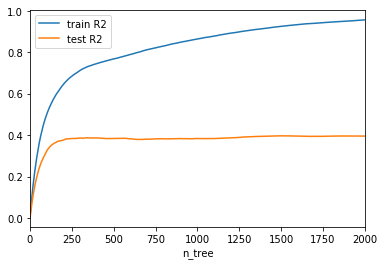

In [16]:
n_trees = 2000
depth = 5

gbt = GradientBoostingRegressor(max_depth=depth,n_estimators=n_trees,learning_rate=0.01)
gbt.fit(features_train,target_train)

n_tree = []
R2_train = []
R2_test = []

target_train_predict = iter(gbt.staged_predict(features_train))
target_test_predict = iter(gbt.staged_predict(features_test))

for k in range(n_trees):
    n_tree.append(k+1)
    R2_train.append(r2_score(target_train,next(target_train_predict)))
    R2_test.append(r2_score(target_test,next(target_test_predict)))
    
performance = pd.DataFrame()
performance['n_tree'] = n_tree
performance['train R2'] = R2_train
performance['test R2'] = R2_test

ax1 = performance.plot.line(x='n_tree',y='train R2')
performance.plot.line(x='n_tree',y='test R2',ax=ax1)

Still overfitting with depth of 20, better with a depth of 5